In [6]:
import pandas as pd
import numpy as np
import re
import scanpy as sc
import anndata
from concurrent.futures import ProcessPoolExecutor,ThreadPoolExecutor, as_completed
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
sc.settings.n_jobs = 60


# Read h5 of CM CD4 T 

In [3]:
adata_CM_CD4=sc.read_h5ad('adata_cm_cd4_processed.h5ad')

In [4]:
adata_sub_subsampled=sc.pp.subsample(adata_CM_CD4, n_obs=100000, random_state=0, copy=True)

/opt/conda/lib/python3.10/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_actio

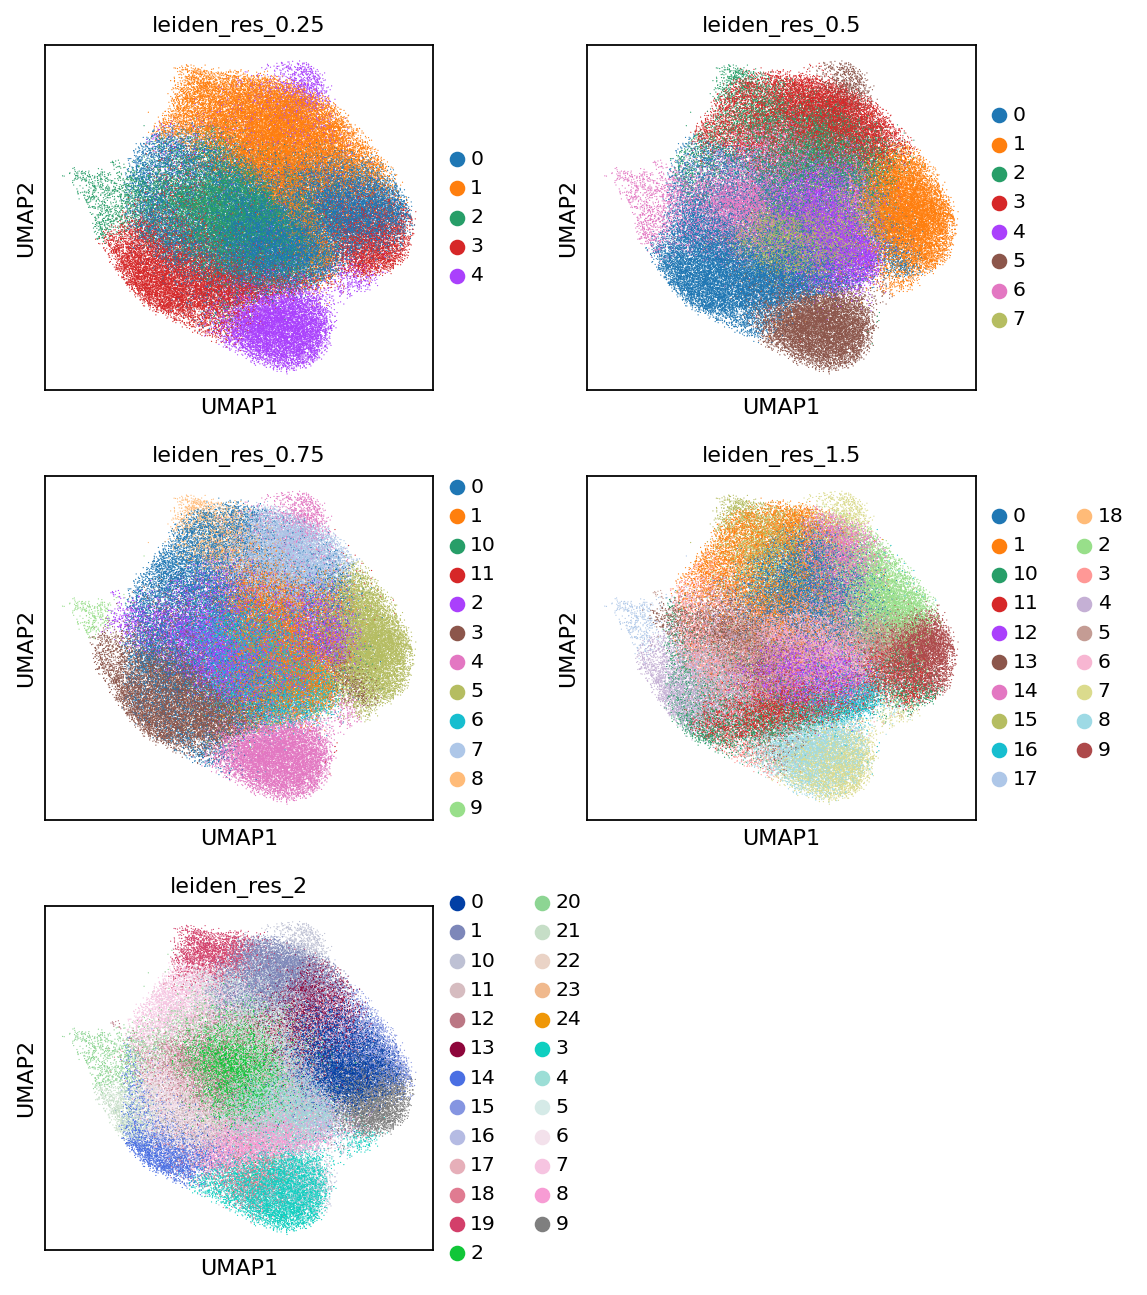

In [7]:
plt.rcParams['figure.figsize'] = [3, 3]

p1=scyan.plot.umap(adata_sub_subsampled, color=['leiden_res_0.25','leiden_res_0.5','leiden_res_0.75','leiden_res_1.5','leiden_res_2'], 
                   show=True, 
                   ncols=2 ,return_fig=True)


In [8]:
adata_sub_subsampled.var_names.sort_values()

Index(['CD127 (IL7Ra)_logicle', 'CD185 (CXCR5)_logicle',
       'CD197 (CCR7)_logicle', 'CD278 (ICOS)_logicle', 'CD279 (PD-1)_logicle',
       'CD27_logicle', 'CD38_logicle', 'CD39_logicle', 'CD3_logicle',
       'CD45_logicle', 'CD4_logicle', 'CD8_logicle', 'CD95_logicle',
       'HLA-DR_logicle', 'KLRG1_logicle', 'TIGIT_logicle'],
      dtype='object')

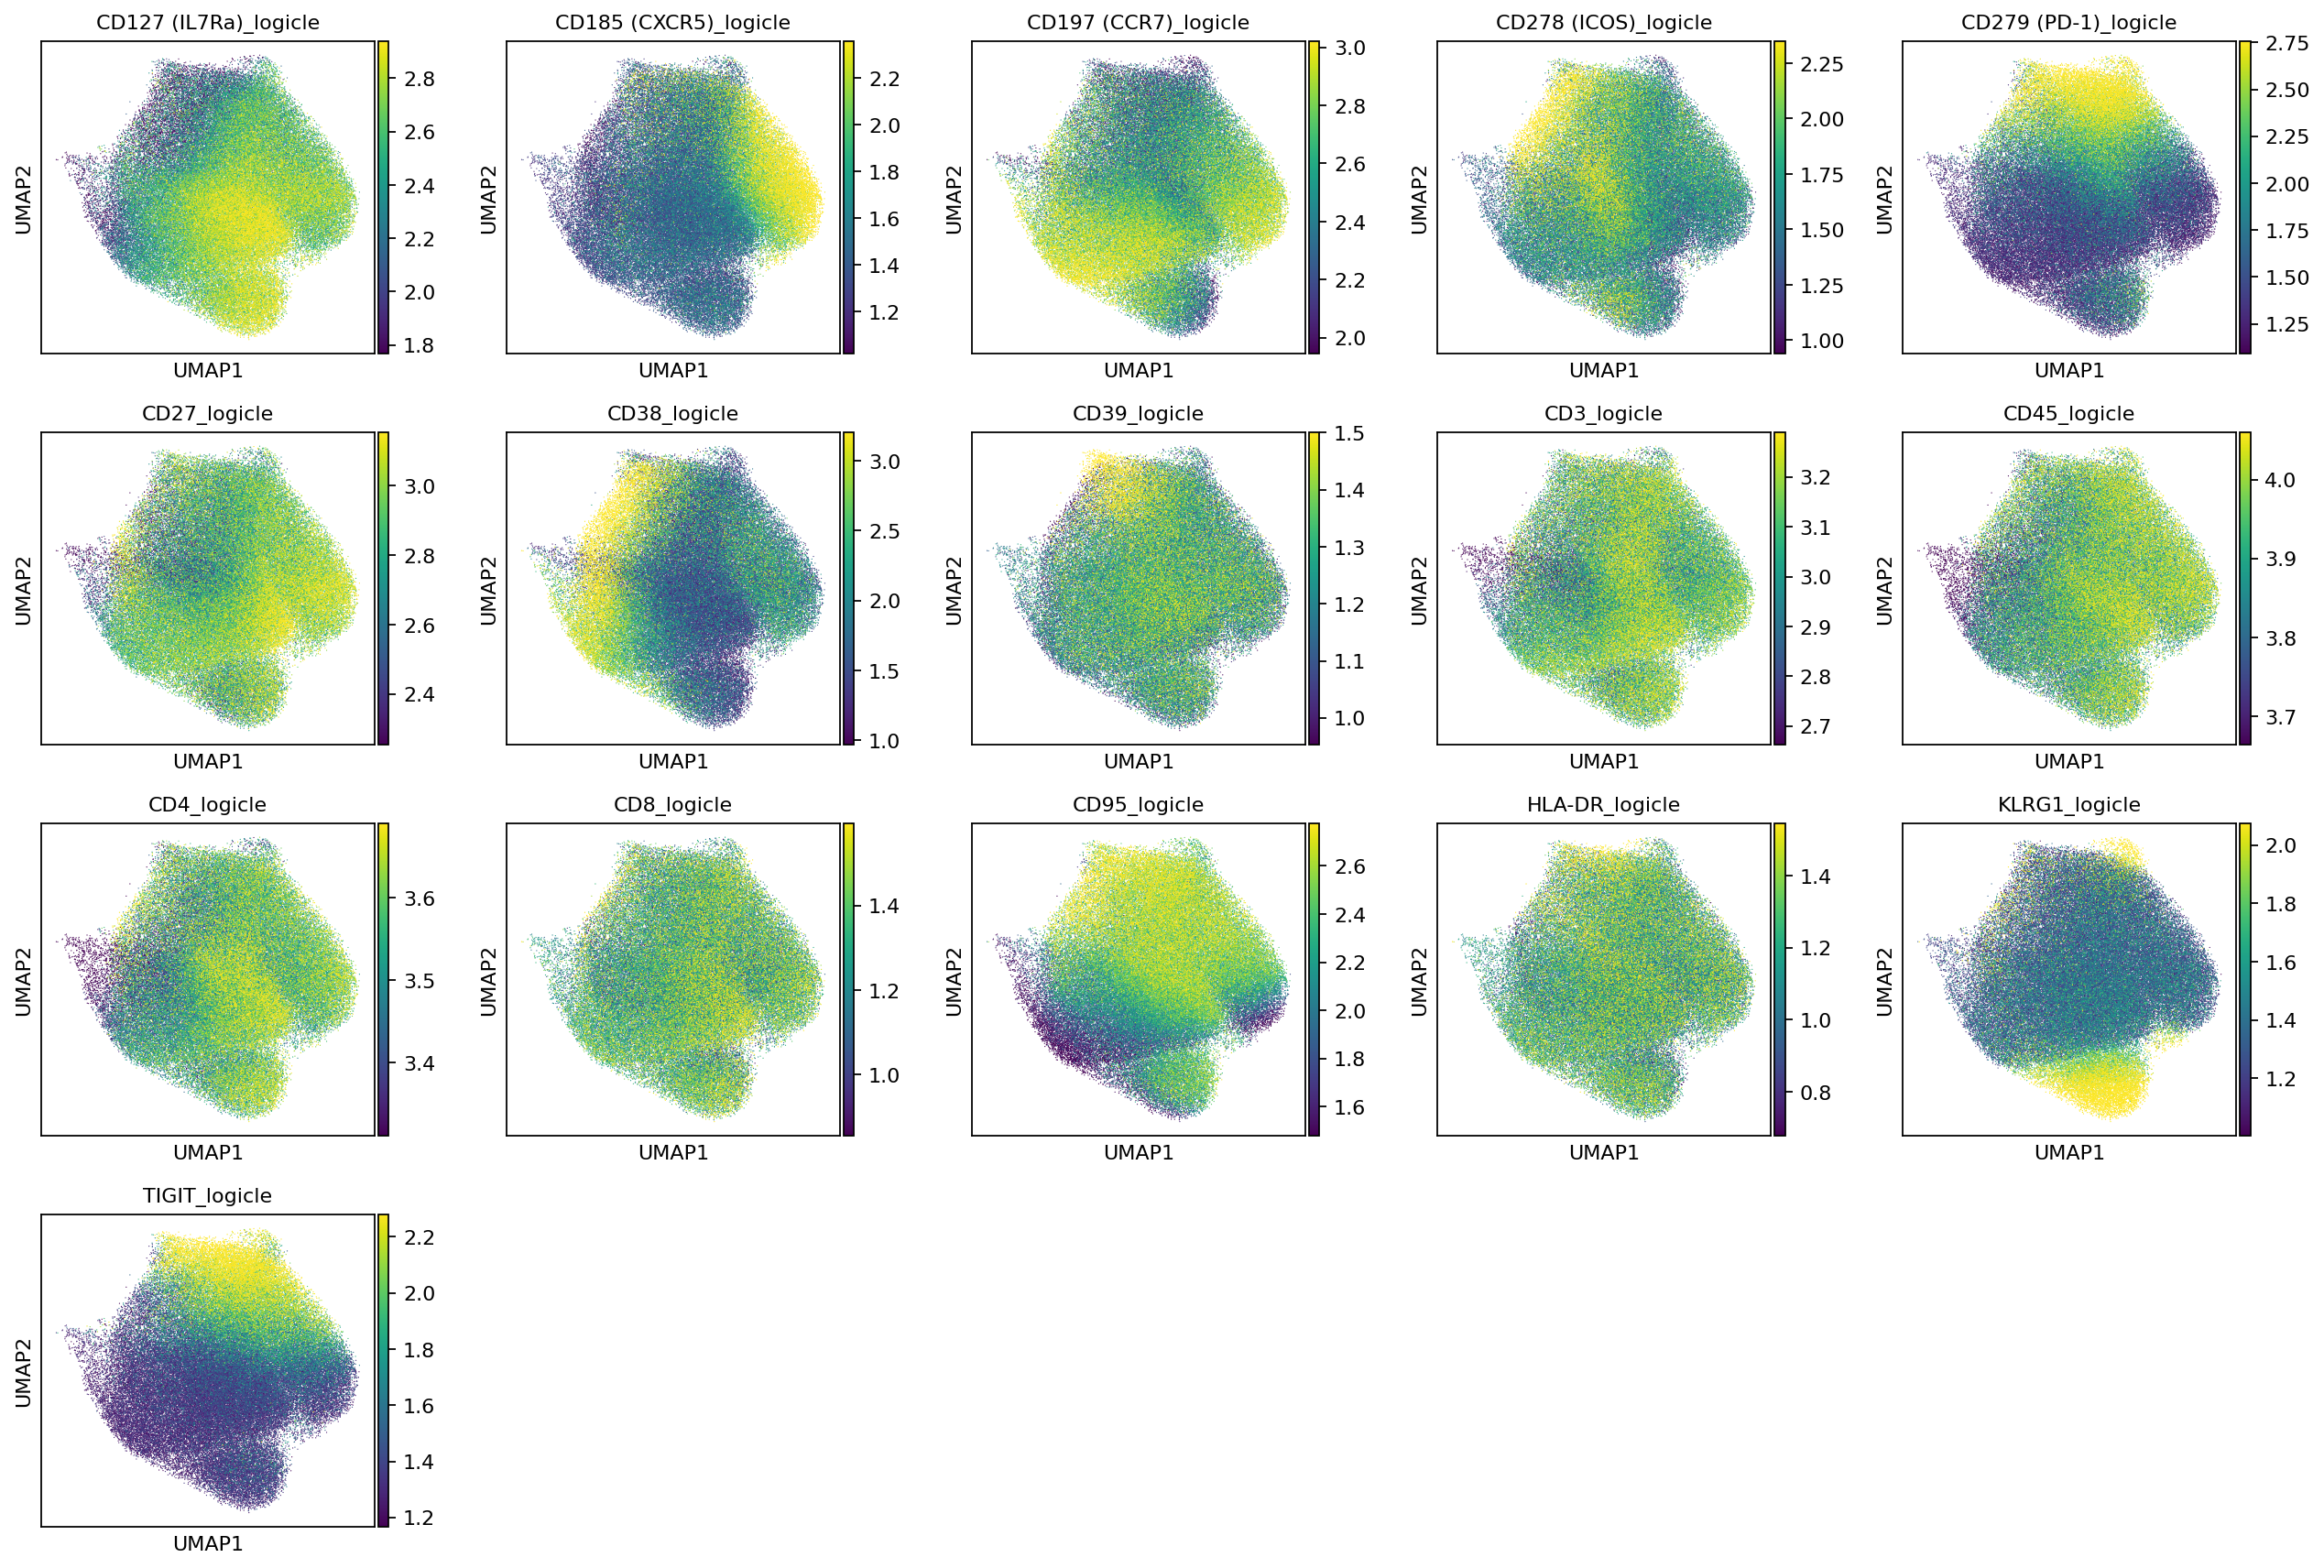

In [9]:
plt.rcParams['figure.figsize'] = [3, 3]

scyan.plot.umap(adata_sub_subsampled, color=adata_sub_subsampled.var_names.sort_values(),ncols=5, show=True)


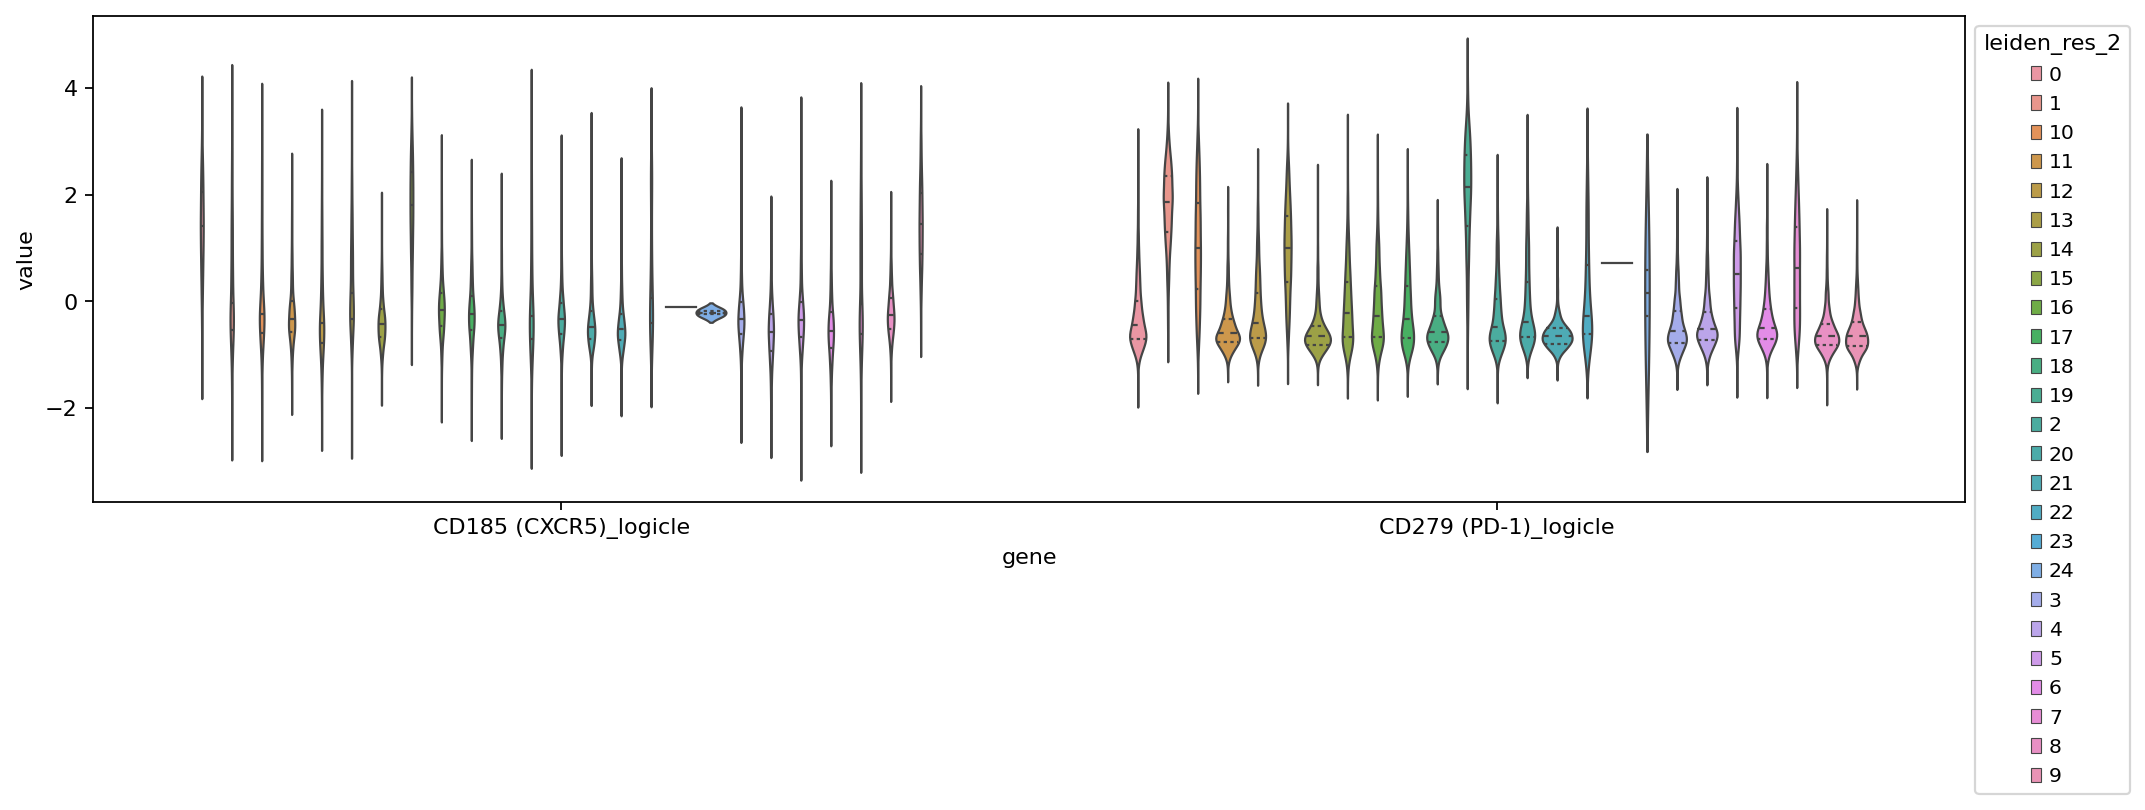

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15, 4]
df = sc.get.obs_df(adata_sub_subsampled, ['CD185 (CXCR5)_logicle','CD279 (PD-1)_logicle','leiden_res_2'])
df = df.set_index('leiden_res_2').stack().reset_index()
df.columns = ['leiden_res_2', 'gene', 'value']
ax=sns.violinplot(data=df, x='gene', y='value', hue="leiden_res_2",
                 inner="quart", linewidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [45]:
adata.obs.loc[adata.obs['barcode'].isin(adata_CM_CD4.obs[adata_CM_CD4.obs['leiden_res_1.5']=='2']['barcode']), 'labels'] = 'CXCR5+ PD1- Tfh'
adata.obs.loc[adata.obs['barcode'].isin(adata_CM_CD4.obs[adata_CM_CD4.obs['leiden_res_1.5']=='9']['barcode']), 'labels'] = 'CXCR5+ PD1+ Tfh'

In [57]:
counts=adata.obs[['labels','sample_id']].value_counts().unstack()

In [60]:
counts.to_csv('Counts.csv')

# Calculate Frequency

In [14]:
counts=pd.read_csv('Counts.csv')

In [15]:
T_cells=['CXCR5+ PD1+ Tfh',
 'CXCR5+ PD1- Tfh',
 'cd103_cd4_t_cells',
 'cd103_cd8_t_cells',
 'cm_cd4_t_cells',
 'cm_cd8_t_cells',
 'dn_t_cells',
 'dp_t_cells',
 'em_cd4_t_cells',
 'em_cd8_t_cells',
 'gd_t_cells',
 'memory_treg',
 'naive_cd4_t_cells',
 'naive_cd8_t_cells',
 'naive_treg',
 'temra_cd4_t_cells']
CD4_T_cells=['CXCR5+ PD1+ Tfh',
 'CXCR5+ PD1- Tfh',
 'cd103_cd4_t_cells',
 'cm_cd4_t_cells',
 'em_cd4_t_cells',
 'memory_treg',
 'naive_cd4_t_cells',
 'naive_treg',
 'temra_cd4_t_cells']

### Freq in total T

In [16]:
counts_T=counts[counts['labels'].isin(T_cells)]
counts_T.index=counts_T['labels']
counts_T=counts_T.iloc[:,1:315]
frequency_matrix_T = counts_T.div(counts_T.sum(axis=0), axis=1)

In [17]:
frequency_matrix_reset = frequency_matrix_T.reset_index()
frequency_matrix_long = frequency_matrix_reset.melt(id_vars='labels', var_name='sample_id', value_name='frequency')

In [20]:
frequency_matrix_long['sample.sampleKitGuid']=['KT'+element.split('-')[0].replace("PB", "") for element in frequency_matrix_long['sample_id']]
metaData=meta_data_selected_RNA[['sample.sampleKitGuid_x','sample.visitName','subject.biologicalSex_x',
                        'cohort.cohortGuid_y','CMV.IgG.Serology.Result.Interpretation' ,'subject.subjectGuid',
                        'Flu_Year', 'Strains_concat']]
metaData.columns=['sample.sampleKitGuid','sample.visitName','subject.biologicalSex',
                        'cohort.cohortGuid','CMV.IgG.Serology.Result.Interpretation' ,'subject.subjectGuid',
                        'Flu_Year', 'Strains_concat']

In [21]:
frequency_matrix_long=frequency_matrix_long.merge(metaData, on='sample.sampleKitGuid', how='left')

In [22]:
frequency_matrix_long.to_csv('freq_T.csv')

### Freq in total CD4 T

In [23]:
counts_T=counts[counts['labels'].isin(CD4_T_cells)]
counts_T.index=counts_T['labels']
counts_T=counts_T.iloc[:,1:315]
frequency_matrix_T = counts_T.div(counts_T.sum(axis=0), axis=1)

In [24]:
frequency_matrix_reset = frequency_matrix_T.reset_index()
frequency_matrix_long = frequency_matrix_reset.melt(id_vars='labels', var_name='sample_id', value_name='frequency')

In [25]:
frequency_matrix_long['sample.sampleKitGuid']=['KT'+element.split('-')[0].replace("PB", "") for element in frequency_matrix_long['sample_id']]
metaData=meta_data_selected_RNA[['sample.sampleKitGuid_x','sample.visitName','subject.biologicalSex_x',
                        'cohort.cohortGuid_y','CMV.IgG.Serology.Result.Interpretation' ,'subject.subjectGuid',
                        'Flu_Year', 'Strains_concat']]
metaData.columns=['sample.sampleKitGuid','sample.visitName','subject.biologicalSex',
                        'cohort.cohortGuid','CMV.IgG.Serology.Result.Interpretation' ,'subject.subjectGuid',
                        'Flu_Year', 'Strains_concat']

In [26]:
frequency_matrix_long=frequency_matrix_long.merge(metaData, on='sample.sampleKitGuid', how='left')

In [27]:
frequency_matrix_long.to_csv('freq_CD4_T.csv')